# 00 import libraries

In [295]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# 01 load data

In [296]:
tf.keras.datasets.cifar10.load_data()

((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

In [297]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [298]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


# 03 preprocessing

In [299]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [300]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 04 data exploration

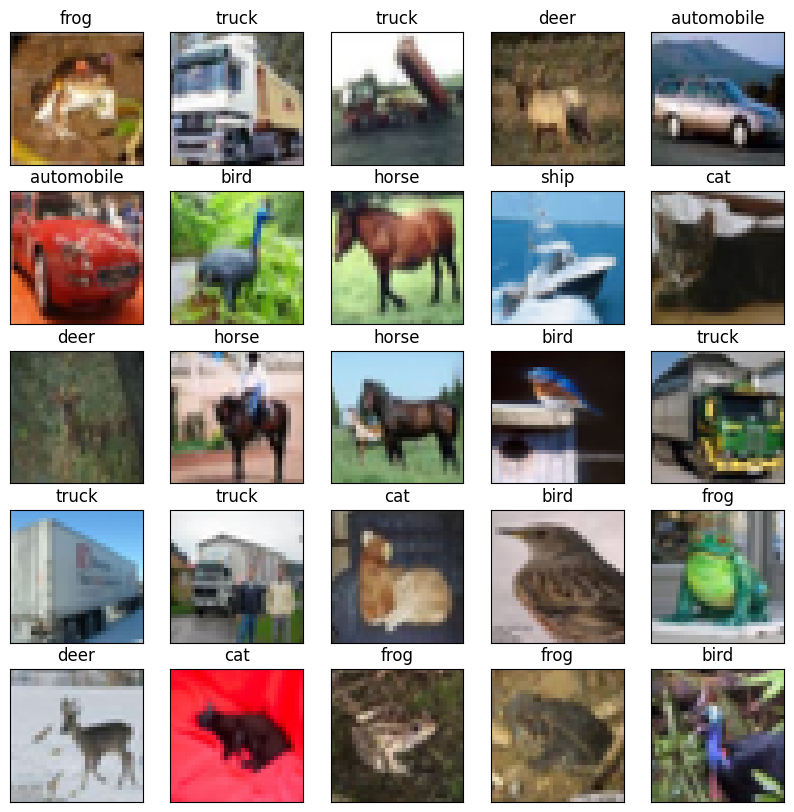

In [301]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.title(class_names[y_train[i][0]])
plt.show()

# 05 hyperparameter

In [302]:
from kerastuner import RandomSearch

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05, default=0.25)
    ))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05, default=0.25)
    ))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.05, default=0.5)
    ))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [303]:
tuner_search = RandomSearch(build_model, objective='val_accuracy', max_trials=5, 
                            directory='output', project_name="Cifar10_CNN")


tuner_search.search(X_train, y_train, epochs=3, validation_split=0.2)


best_hps = tuner_search.get_best_models(num_models=1)[0]

INFO:tensorflow:Reloading Tuner from output/Cifar10_CNN/tuner0.json


INFO:tensorflow:Reloading Tuner from output/Cifar10_CNN/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [304]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 112)       3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        179264    
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 96)        55392     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 96)          0         
 g2D)                                                   

In [307]:
print(best_hps.values)


{'num_layers': 2, 'units_0': 736, 'units_1': 832, 'learning_rate': 0.0001, 'units_2': 1312, 'units_3': 1824, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013', 'units_4': 896}


# 06 defining model

In [337]:
class BestCNN(keras.Model):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = keras.layers.Conv2D(112, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3))
        self.maxpool1 = keras.layers.MaxPooling2D((2, 2))
        self.dropout1 = keras.layers.Dropout(0.25)

        self.conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = keras.layers.MaxPooling2D((2, 2))
        self.dropout2 = keras.layers.Dropout(0.25)

        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(160, activation='relu')
        self.out = keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.dense1(x)

        return self.out(x)

model = BestCNN()
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])


# 07 model training

In [354]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
782/782 [==============================] - 37s 47ms/step - loss: 0.2878 - accuracy: 0.9014 - val_loss: 0.7911 - val_accuracy: 0.7538
Epoch 2/50
782/782 [==============================] - 38s 49ms/step - loss: 0.2826 - accuracy: 0.9026 - val_loss: 0.7980 - val_accuracy: 0.7532
Epoch 3/50
782/782 [==============================] - 38s 49ms/step - loss: 0.2760 - accuracy: 0.9037 - val_loss: 0.7958 - val_accuracy: 0.7567
Epoch 4/50
782/782 [==============================] - 38s 48ms/step - loss: 0.2675 - accuracy: 0.9083 - val_loss: 0.8075 - val_accuracy: 0.7532
Epoch 5/50
782/782 [==============================] - 40s 51ms/step - loss: 0.2594 - accuracy: 0.9121 - val_loss: 0.8090 - val_accuracy: 0.7525
Epoch 6/50
782/782 [==============================] - 38s 49ms/step - loss: 0.2529 - accuracy: 0.9131 - val_loss: 0.8150 - val_accuracy: 0.7532
Epoch 7/50
782/782 [==============================] - 37s 47ms/step - loss: 0.2456 - accuracy: 0.9162 - val_loss: 0.8238 - val_accuracy:

# 08 model evaluation

In [355]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test accuracy: ", test_accuracy)
print("Test loss: ", test_loss)

313/313 [==============================] - 2s 7ms/step - loss: 1.0700 - accuracy: 0.7496
Test accuracy:  0.7495999932289124
Test loss:  1.069994330406189


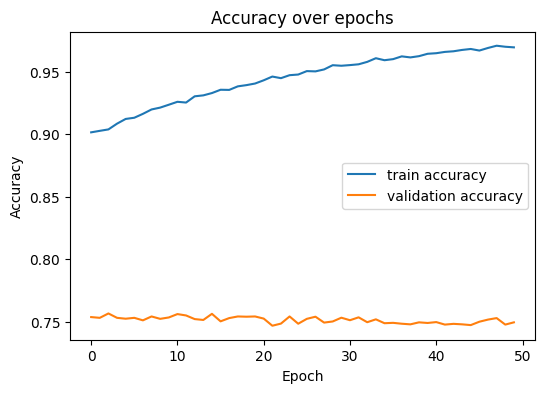

In [356]:

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


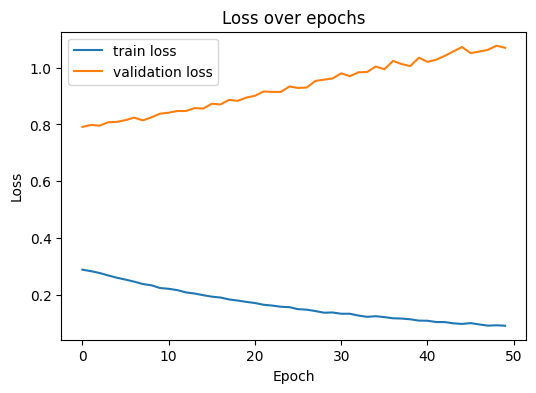

In [357]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 09 testing

In [360]:
import random

1/1 [==============================] - 0s 17ms/step


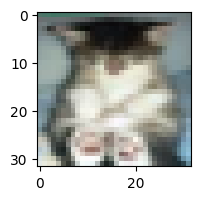

Predicted Label:  3
Actual Label:  [3]
1/1 [==============================] - 0s 9ms/step


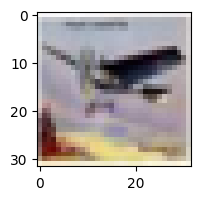

Predicted Label:  0
Actual Label:  [0]
1/1 [==============================] - 0s 8ms/step


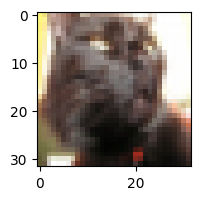

Predicted Label:  3
Actual Label:  [3]
1/1 [==============================] - 0s 10ms/step


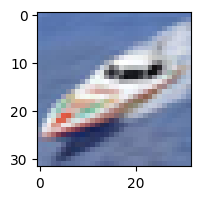

Predicted Label:  8
Actual Label:  [8]
1/1 [==============================] - 0s 10ms/step


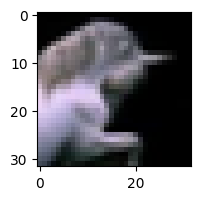

Predicted Label:  2
Actual Label:  [7]
1/1 [==============================] - 0s 11ms/step


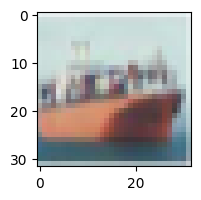

Predicted Label:  8
Actual Label:  [8]
1/1 [==============================] - 0s 8ms/step


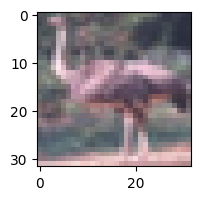

Predicted Label:  4
Actual Label:  [2]
1/1 [==============================] - 0s 10ms/step


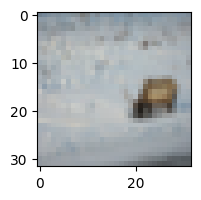

Predicted Label:  0
Actual Label:  [4]
1/1 [==============================] - 0s 8ms/step


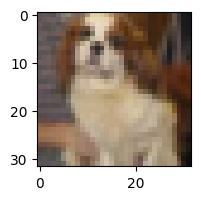

Predicted Label:  5
Actual Label:  [5]
1/1 [==============================] - 0s 10ms/step


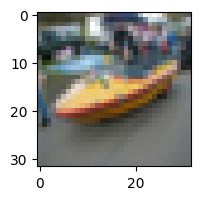

Predicted Label:  1
Actual Label:  [8]


In [361]:
for _ in range(10):
    i = random.randint(0, len(X_test) - 1) 
    img = np.expand_dims(X_test[i], axis=0) 
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction) 

    
    plt.figure(figsize=(2,2))
    plt.imshow(X_test[i])
    plt.show()
    
    print("Predicted Label: ", predicted_label)
    print("Actual Label: ", y_test[i])
